<a href="https://colab.research.google.com/github/cweidig/measuring_bias/blob/main/measure_bias_preprocess_2chart_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read the file mortgage_data_project.pkl from Google drive with pandas' read_pickle()
import pandas as pd
import seaborn as sns
import numpy as np

# Load the datset into a pandas dataframe
from joblib import load

df = load("/content/drive/My Drive/mortgage_data_preprocessed.pkl.gz")

In [19]:
# Install AIF360
!pip install aif360

In [17]:
# Train a logistic regression classifier and calculate fairness metrics and performance metrics

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



In [16]:
# Consider the target variable (y) the action_taken_name. The input variables set (X) should contain all the remaining variables

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

In [21]:
"""
Split the data using the cross-validator instantiated in the configuration step above.
For each split,
Fit a model using the logistic regression classifier on the training set.
Compute the predicted class labels and probability estimates for the test set.
Compute performance metrics using sklearn: accuracy_score, precision_score, recall_score, roc_auc_score, f1_score.
Compute fairness metrics using AIF360 (see below).
Compute the mean and standard deviation over the 10 folds for each performance and fairness metric and print them in a table
"""

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score,
                "F1-Score": metrics.f1_score,
                }

# Create a Binary Label Dataset from the training data
from aif360.datasets import BinaryLabelDataset
dataset = BinaryLabelDataset(df=df, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

# set up the fairness metrics
from aif360.metrics import ClassificationMetric
privileged_group = [{'applicant_sex_name_Female': 0}]
unprivileged_group = [{'applicant_sex_name_Female': 1}]

# Split the input and output variables using the cross-validator skf
import pandas as pd
import numpy as np
k, i = True, 1

for (train, test) in skf.split(X, y):
    # fit model
    lr = log_reg.fit(X.iloc[train], y.iloc[train].values.ravel())

    # get predictions in the test set
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    dataset = X.iloc[test].copy()
    dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
    dataset = BinaryLabelDataset(df=dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    dataset_pred = X.iloc[test].copy()
    dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
    dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Disparate Impact', metric_CM.disparate_impact()]]
    metrics += [['Equal Opportunity Difference', metric_CM.equal_opportunity_difference()]]
    metrics += [['Average Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['Accuracy Male', metric_CM.accuracy(privileged=True)]]
    metrics += [['Accuracy Female', metric_CM.accuracy(privileged=False)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentati

In [22]:
# Display metrics
metrics_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table

,mean,std
,Value,Value
Metric,,
AUC,0.789560,0.004415
Accuracy,0.693124,0.004840
Accuracy Female,0.661655,0.005407
Accuracy Male,0.706970,0.005939
Average Odds Difference,0.139619,0.006288
Disparate Impact,1.513802,0.025461
Equal Opportunity Difference,0.115410,0.008036
F1-Score,0.635675,0.007267


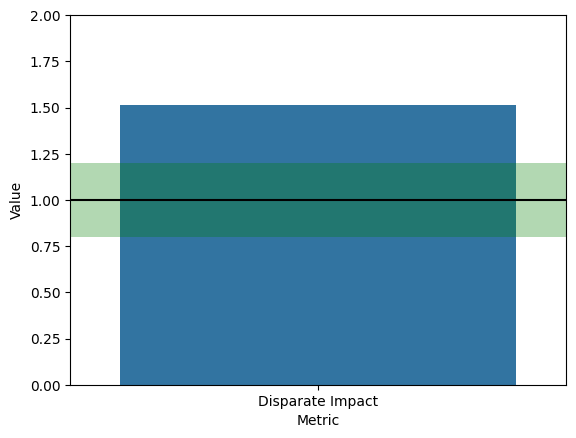

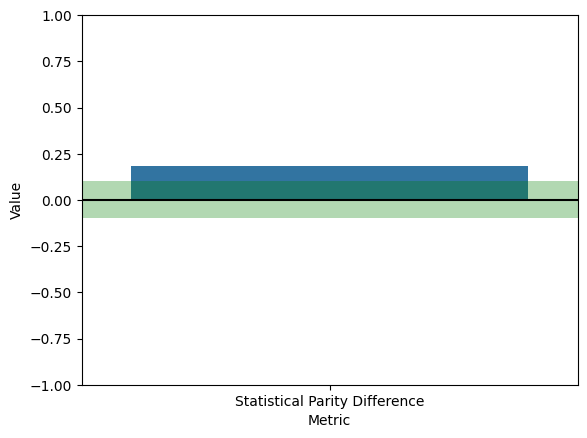

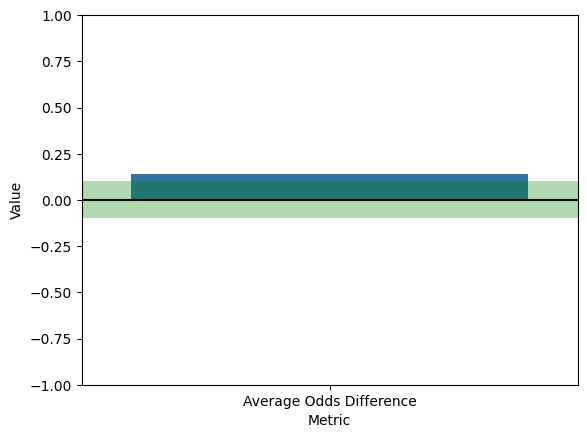

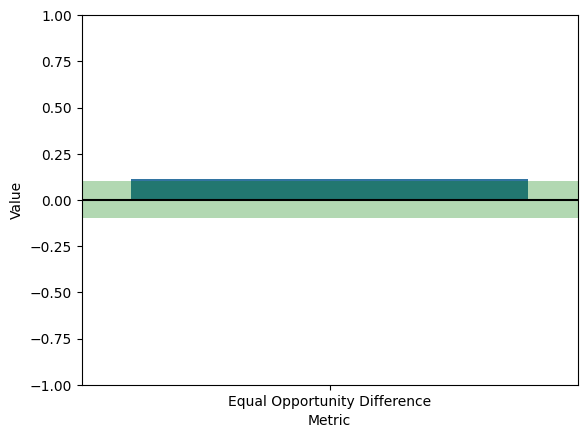

In [33]:
# Use matplotlib to visually show on a graph the 10-fold CV average for each fairness metric with its allowable range
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

fairness_metrics = metrics_table.filter(regex='Disparate|Difference',axis=0)
fairness_df = pd.DataFrame(columns=["Metric", "Value", "Min", "Max"])
fairness_df.loc[0] = ['Disparate Impact'] + list((fairness_metrics[('mean', 'Value')]['Disparate Impact'], 0.8, 1.2))
fairness_df.loc[1] = ['Statistical Parity Difference'] + list((fairness_metrics[('mean', 'Value')]['Statistical Parity Difference'], -0.1, 0.1))
fairness_df.loc[2] = ['Average Odds Difference'] + list((fairness_metrics[('mean', 'Value')]['Average Odds Difference'], -0.1, 0.1))
fairness_df.loc[3] = ['Equal Opportunity Difference'] + list((fairness_metrics[('mean', 'Value')]['Equal Opportunity Difference'], -0.1, 0.1))

def plot_metrics(df_fair):
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))
  plot_metric(df_fair.iloc[[2]], (-1, 1))
  plot_metric(df_fair.iloc[[3]], (-1, 1))

plot_metrics(fairness_df)